In [2]:

import numpy as np
import pandas as pd

from google.colab import files
upload = files.upload()

#You can download the dataset:  
#https://www.kaggle.com/tmdb/tmdb-movie-metadata/downloads/tmdb-5000-movie-dataset.zip/2
credit = pd.read_csv("tmdb_5000_credits.csv")

movie_incomplete = pd.read_csv("tmdb_5000_movies.csv")

print("Credit:", credit.shape)
print("Movie_incomplete:", movie_incomplete.shape)

Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv
Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv
Credit: (4803, 4)
Movie_incomplete: (4803, 20)


In [3]:
# Credit to Ibtesam Ahmed for her kernel:
# https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system


credits_renamed = credit.rename(index = str, columns={"movie_id":"id"})
movies_dirty = movie_incomplete.merge(credits_renamed, on="id")
movies_dirty.head()
                                     

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
movies_clean = movies_dirty.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])
movies_clean.head()




,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


#Basic Recommender Systems

##The formula IMDB
![alt text](https://cdn-images-1.medium.com/max/800/1*fGziZl2Do-VyQXSCPq_Y2Q.png)

In [0]:
#we’ll use the formula IMDB (formerly) used to calculate weighted ratings for movies
#http://trailerpark.weebly.com/imdb-rating.html

V = movies_clean['vote_count']
R = movies_clean['vote_average']
C = movies_clean['vote_average'].mean()
m = movies_clean['vote_count'].quantile(0.70)

movies_clean['weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)

In [6]:
movies_ranked = movies_clean.sort_values('weighted_average', ascending=False)
movies_ranked[['original_title', 'vote_count', 'vote_average', 'weighted_average', 'popularity']].head(20)



,original_title,vote_count,vote_average,weighted_average,popularity
1881,The Shawshank Redemption,8205,8.5,8.340775,136.747729
3337,The Godfather,5893,8.4,8.192887,143.659698
662,Fight Club,9413,8.3,8.171648,146.757391
3232,Pulp Fiction,8428,8.3,8.157615,121.463076
65,The Dark Knight,12002,8.2,8.102674,187.322927
809,Forrest Gump,7927,8.2,8.056059,138.133331
1818,Schindler's List,4329,8.3,8.038748,104.469351
3865,Whiplash,4254,8.3,8.034695,192.528841
96,Inception,13752,8.1,8.018611,167.583710
1990,The Empire Strikes Back,5879,8.2,8.010426,78.517830


### Recommend ten movies with the highest weighted average ratings

Text(0, 0.5, 'Movie Title')

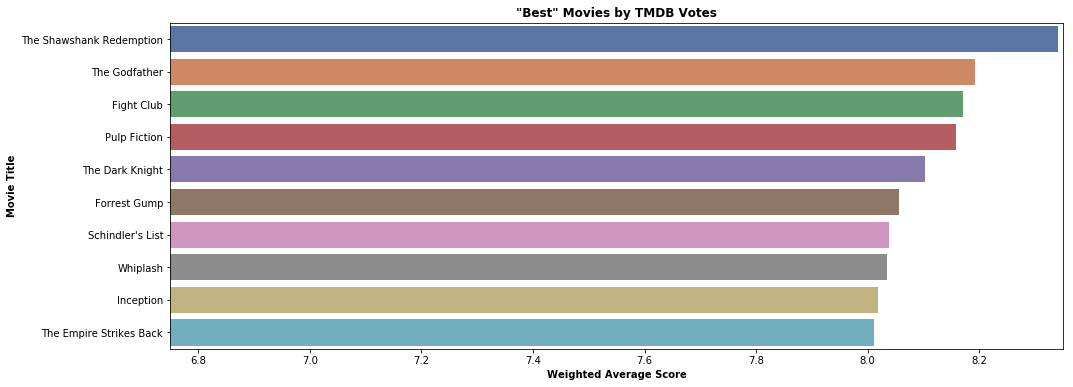

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

wavg = movies_ranked.sort_values('weighted_average', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=wavg['weighted_average'].head(10), y=wavg['original_title'].head(10), data=wavg, palette='deep')

plt.xlim(6.75, 8.35)
plt.title('"Best" Movies by TMDB Votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')


### Recommend ten movies with the highest  ratings

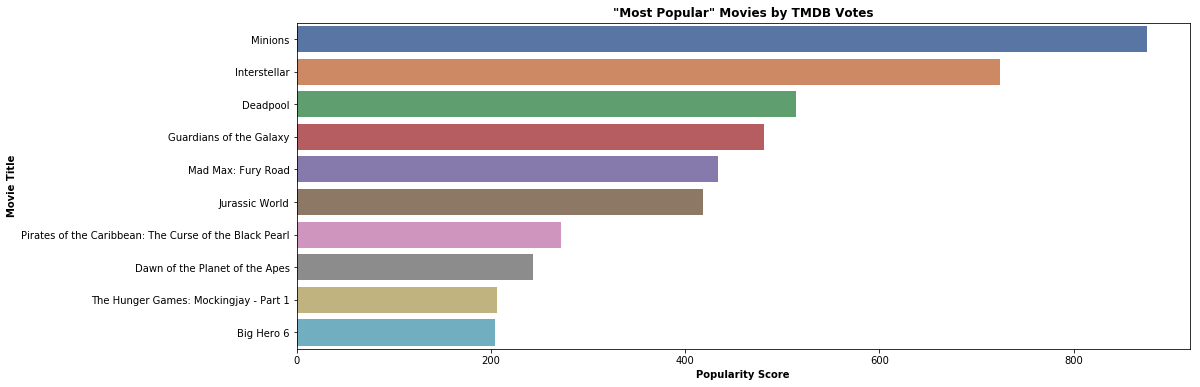

In [8]:
popular = movies_ranked.sort_values("popularity", ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=popular["popularity"].head(10),y=popular["original_title"].head(10),data=popular, palette='deep')

plt.title('"Most Popular" Movies by TMDB Votes', weight='bold')
plt.xlabel('Popularity Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')


plt.savefig('popular_movies.png')

####In order to avoid the colossal popularity score of Minions skewing our new scoring system, I normalized the values in both the weighted_average and popularity columns. I decided to go with a 50/50 split between the scaled weighted average rating and popularity scores, you can have another way to split.

In [12]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
movies_scaled = min_max_scaler.fit_transform(movies_clean[['weighted_average', 'popularity']]) 
movies_norm = pd.DataFrame(movies_scaled,columns=['weighted_average', 'popularity'])
movies_norm.head()

,weighted_average,popularity
0,0.674339,0.171815
1,0.581403,0.158846
2,0.436273,0.122635
3,0.773054,0.128272
4,0.387739,0.050169


In [15]:
movies_clean[['norm_weighted_average', 'norm_popularity']] = movies_norm
movies_clean.head(4)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew,weighted_average,norm_weighted_average,norm_popularity
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.148013,0.674339,0.171815
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.807627,0.581403,0.158846
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.276075,0.436273,0.122635
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",7.509565,0.773054,0.128272


In [16]:
movies_clean["score"] = movies_clean['norm_weighted_average'] * 0.5 + movies_clean['norm_popularity'] * 0.5
movies_scored = movies_clean.sort_values(["score"], ascending=False)
movies_scored[['original_title', 'norm_weighted_average', 'norm_popularity', 'score']].head(20)

,original_title,norm_weighted_average,norm_popularity,score
95,Interstellar,0.906439,0.827162,0.866801
546,Minions,0.460630,1.000000,0.730315
94,Guardians of the Galaxy,0.851874,0.549462,0.700668
788,Deadpool,0.725217,0.587690,0.656453
127,Mad Max: Fury Road,0.670973,0.495989,0.583481
1881,The Shawshank Redemption,1.000000,0.156179,0.578090
65,The Dark Knight,0.934991,0.213941,0.574466
3865,Whiplash,0.916431,0.219887,0.568159
3337,The Godfather,0.959622,0.164074,0.561848
662,Fight Club,0.953823,0.167611,0.560717


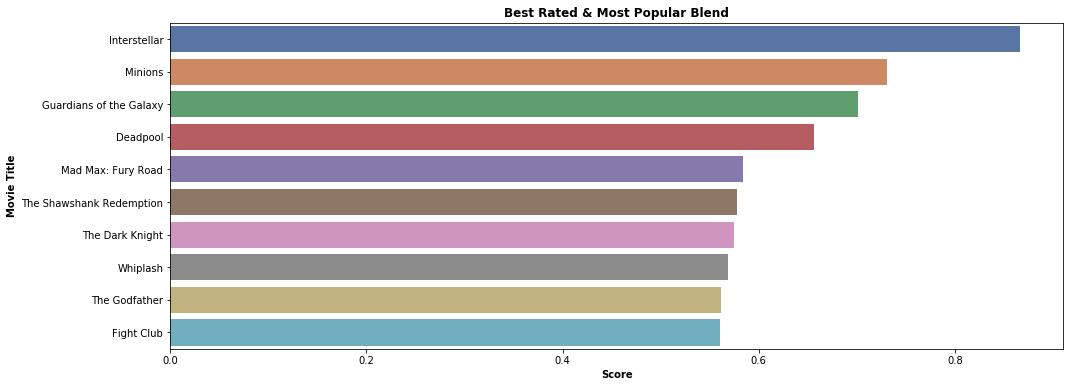

In [17]:
scored = movies_clean.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored['score'].head(10), y=scored['original_title'].head(10), data=scored, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('scored_movies.png')


#Content-Based Filtering¶


###Word Vectorization and TF-IDF
TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using Abhishek Thakur's arguments for TF-IDF
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Filling NaNs with empty string
movies_clean['overview'] = movies_clean['overview'].fillna('')
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(movies_clean['overview'])

tfv_matrix.shape

(4803, 10417)

###Calculating Similarity Scores

In [0]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

# Reverse mapping of indices and movie titles
indices = pd.Series(movies_clean.index, index=movies_clean['original_title']).drop_duplicates()

In [0]:
# Credit to Ibtesam Ahmed for the skeleton code
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return movies_clean['original_title'].iloc[movie_indices]

In [30]:
#Test
give_rec('Avatar')

634                          The Matrix
1341                   Obitaemyy Ostrov
2130                       The American
775                           Supernova
3604                          Apollo 18
529                    Tears of the Sun
151                             Beowulf
942                    The Book of Life
311        The Adventures of Pluto Nash
36      Transformers: Age of Extinction
Name: original_title, dtype: object